# Preliminaries

This is to ensure that torch recognizes macOS software. 

In [74]:
import torch 
print("PyTorch Ver:", torch.__version__) 
print("Apple Silicon available:", torch.backends.mps.is_available())

device = torch.device("mps")

PyTorch Ver: 2.6.0
Apple Silicon available: True


# Imports 

In [73]:
import torch.nn as nn 
import matplotlib.pyplot as plt 
import torch.optim as optimizer 

# Create The Model

Creating a simple neural network with torch for nonlinear regression.


In [115]:
class SimpleNN(nn.Module): # SimpleNN inherits nn.Module from here 
    def __init__(self, input_dim, hidden_dim1=6, hidden_dim2=4):
        super(SimpleNN, self).__init__()  # calls the parent class nn.Module to get pytorch backend set up 
        # Layers 
        self.fc1 = nn.Linear(input_dim, hidden_dim1)  # fc stands for "fully connected" 
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        
        self.relu = nn.ReLU() 
    
    def forward(self, x):
        x = self.relu(self.fc1(x)) # hidden layer 1 
        x = self.relu(self.fc2(x)) # hidden layer 2
        x = self.fc3(x)            # output layer (unbounded since lin reg)
        return x

# Creating a Dummy Dataset

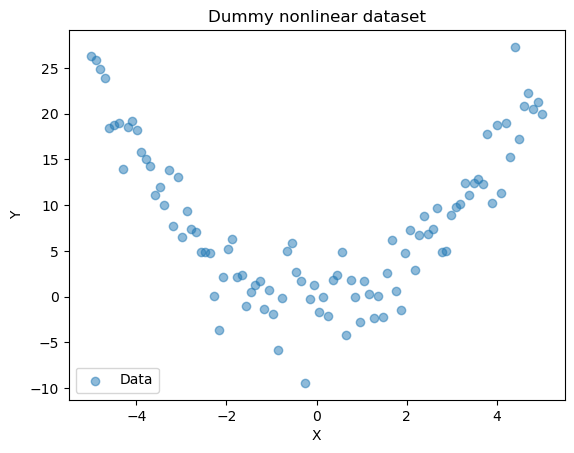

In [55]:
# Generate dataset y = f(x) 
X = torch.linspace(-5, 5, 100).view(-1, 1)
y = X.pow(2) + torch.randn(X.shape) * 3

D = {"X": X, "y": y}

# Plot 
plt.scatter(D["X"].numpy(), D["y"].numpy(), label="Data", alpha=0.5)
plt.xlabel("X") 
plt.ylabel("Y") 
plt.title("Dummy nonlinear dataset")
plt.legend()
plt.show()


# Training Loop


In [116]:
def train(model, dataset, criterion, optimizer, device, print_loss ,epochs=5): 
    """
    Trains the model on the dataset. 

    Args: 
        model: the simple NN model with one hidden layer. 
        dataset: the dataset, a dictionary = {"X": X, "y":y}
        criterion: the loss function to use. 
        optimizer: the type of optimizer to use. 
        epochs: the number of epochs. 
    """
    model = model.to(device) # change all model weights to mps 
    
    model.train() # set the model to train mode (for pytorch)

    final_loss = 0 

    for epoch in range(epochs):       
        optimizer.zero_grad()

        # get data 
        x = dataset["X"]
        y = dataset["y"] 

        x = x.to(device)
        y = y.to(device)

        # forward pass on nn 
        y_hat = model.forward(x) 
        
        loss = criterion(y_hat, y)

        # run back prop on loss to update gradients 
        loss.backward() 

        # update weights 
        optimizer.step() 

        if print_loss:
            print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

        if epoch == epochs - 1:
            final_loss = loss.item()
    
    print(f"Finished training with loss: {final_loss}")
    


# Create and Train the Model

In [118]:
model = SimpleNN(input_dim = 1)
model_optimizer = optimizer.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
dataset = D 
print("Training the Neural Network:")
train(model, dataset, criterion, model_optimizer, device, print_loss=False, epochs=3000)

Training the Neural Network:
Finished training with loss: 7.823089599609375


# Evaluating and Visualizing the Model

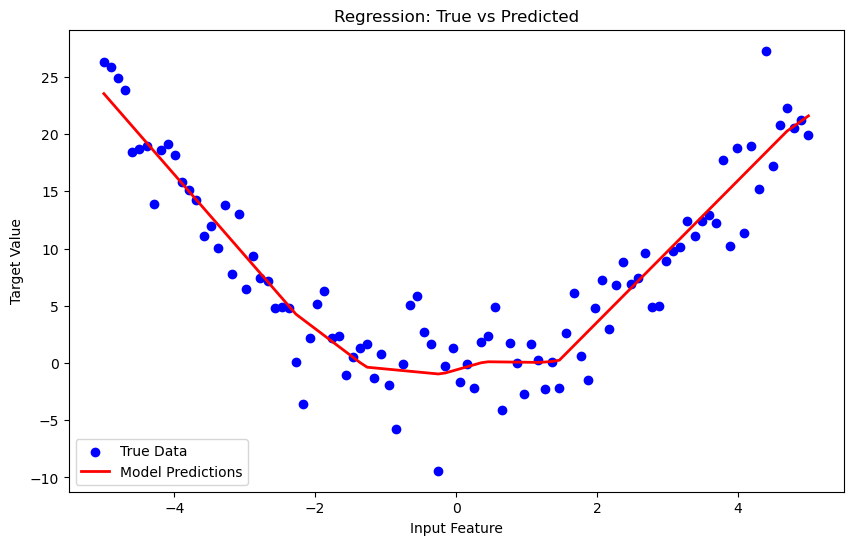

In [119]:
X = X.to(device) 

# Change the model to evaluation mode (changes some backend stuff in PyTorch)
model.eval() 
with torch.no_grad(): 
    y_pred = model.forward(X)

plt.figure(figsize=(10, 6)) 
plt.scatter(X.to("cpu"), y.to("cpu"), label="True Data", color="blue")
plt.plot(X.to("cpu"), y_pred.to("cpu"), label="Model Predictions", color="red", linewidth=2)
plt.xlabel("Input Feature") 
plt.ylabel("Target Value") 
plt.title("Regression: True vs Predicted")
plt.legend()
plt.show()